## Noise source inversion - Gradients for 1st iteration

### Here we use the GI built-in functions to compute sensitivity kernels / gradients for each station-station pair. Rather than gridsearch over the spatial domain as in MFP, we instead use the correlation wavefield and it's adjoint to determine where our source model should be perturbed.


In [1]:
# Python 3.7

import sys
sys.path.append('../GI1_v0.2.1')
sys.path.append('../GI1_v0.2.1/PLOT/')
sys.path.append('../GI1_additions')


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import green as g
import source as s
import processing as proc
import parameters
import time
import random
from correlation_random import *
from correlation_function import *
from correlation_field import *
from kernels import *
from adsrc import *
from earthquakes import *

# The following are newly added, as compared to the original GI code.
from generate_random_signals import *
from specshift import *

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = [20, 10]

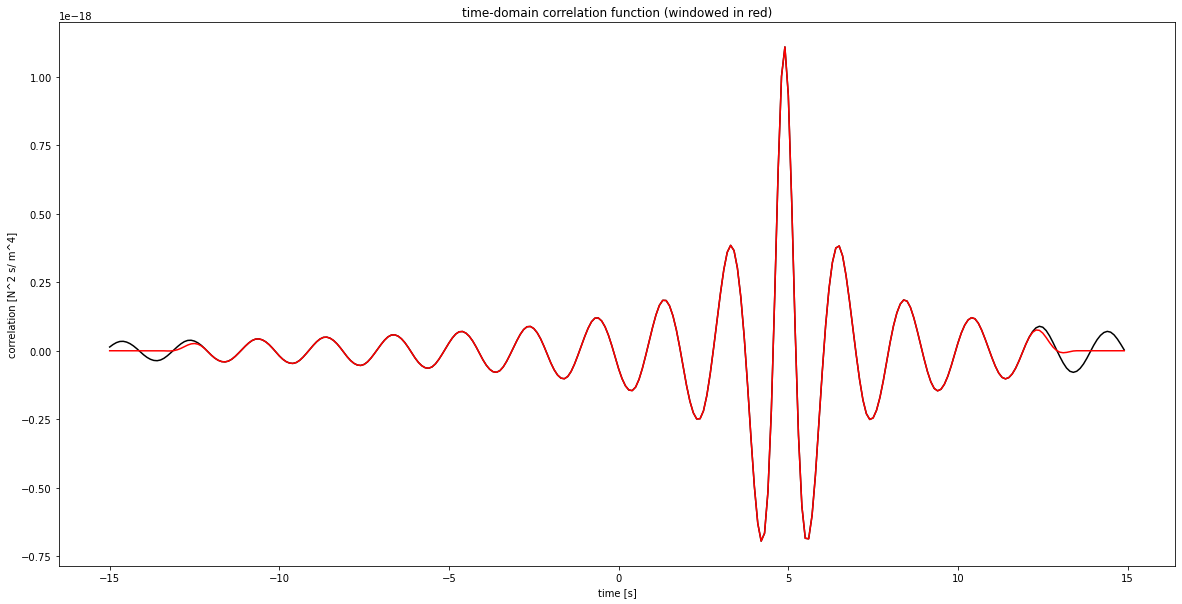

../GI1_v0.2.1/kernels.py:120: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(x-p.dx/2,y-p.dy/2,K_source,cmap=cmap,shading='interp')


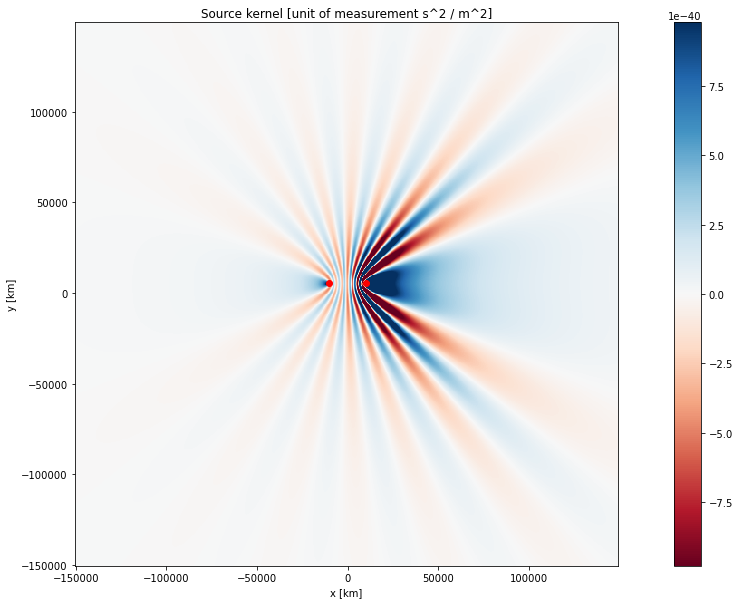

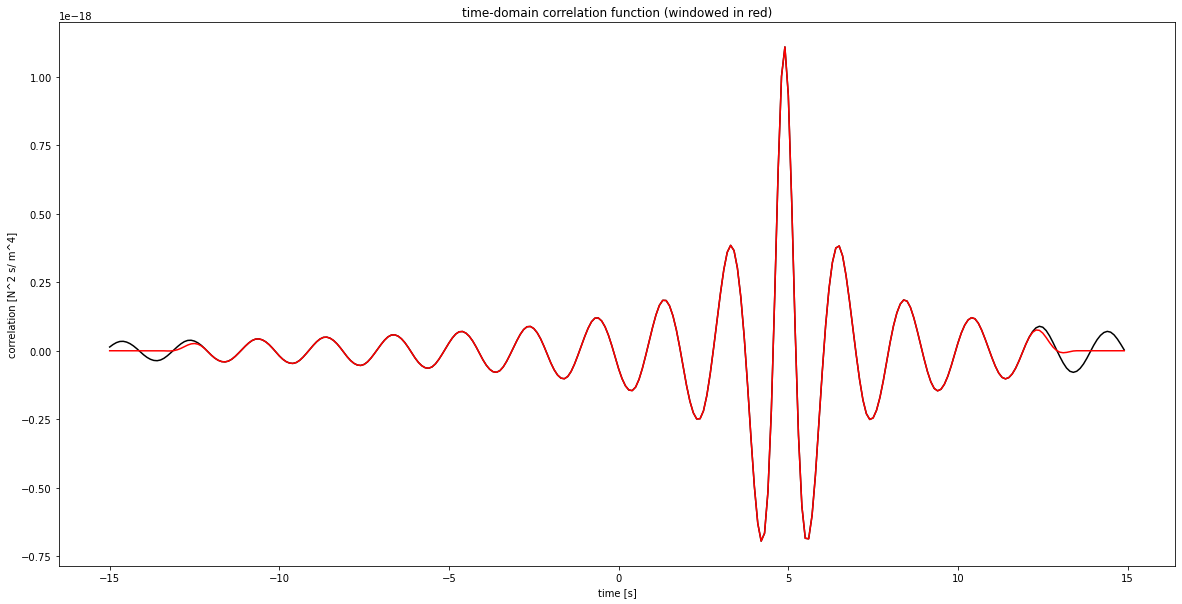

../GI1_v0.2.1/kernels.py:120: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(x-p.dx/2,y-p.dy/2,K_source,cmap=cmap,shading='interp')


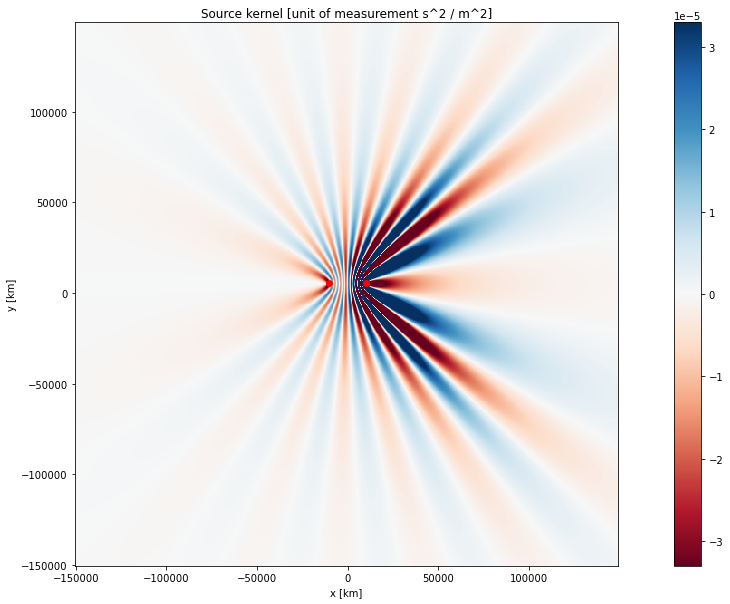

In [3]:
# Rather than gridsearch over points like in MFP, we'll just directly compute the 
#  source kernels using the GI code. 

# See how one kernel looks
cct,t,ccf,f = correlation_function(rec0=0,rec1=1,effective=0,plot=0)
x,y,K_amp = source_kernel(cct, t, rec0=0, rec1=1, measurement='amp', effective=0, plot=1)
x,y,K_cctime = source_kernel(cct, t, rec0=0, rec1=1, measurement='cctime', effective=0, plot=1)

In [4]:
# Lets add together ALL the spatial source kernels

p=parameters.Parameters()
xx = p.x/1000
yy = p.y/1000

K_all = np.zeros([p.Nreceivers**2-p.Nreceivers,np.shape(x)[0],np.shape(x)[1]])
counter = 0
for i1 in range(0,p.Nreceivers):
    for i2 in range(0,p.Nreceivers):
        if(i1==i2):
            continue
        print(i1,i2)
        cct,t,ccf,f = correlation_function(rec0=i1,rec1=i2,effective=0,plot=0,save=1)
        x,y,K_all[counter,:,:] = source_kernel(cct, t, rec0=i1, rec1=i2, measurement='amp', effective=0, plot=0)
        counter = counter+1

K_mean = np.mean(K_all,0)
K_sum = np.sum(K_all,0)
np.save('4_Ksum', K_sum)


# We know where the source actually is:
x0=0.75*p.xmax
y0=0.75*p.ymax

0 1


../GI1_additions/source.py:574: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x/1000.0,y/1000.0,S,cmap='Greys')


0 2


../GI1_additions/source.py:574: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x/1000.0,y/1000.0,S,cmap='Greys')


1 0


../GI1_additions/source.py:574: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x/1000.0,y/1000.0,S,cmap='Greys')


1 2


../GI1_additions/source.py:574: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x/1000.0,y/1000.0,S,cmap='Greys')


2 0


../GI1_additions/source.py:574: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x/1000.0,y/1000.0,S,cmap='Greys')


2 1


../GI1_additions/source.py:574: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x/1000.0,y/1000.0,S,cmap='Greys')


<Figure size 1440x720 with 0 Axes>

/Users/korbinian/Applications/miniconda3/envs/beamforming_environment/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


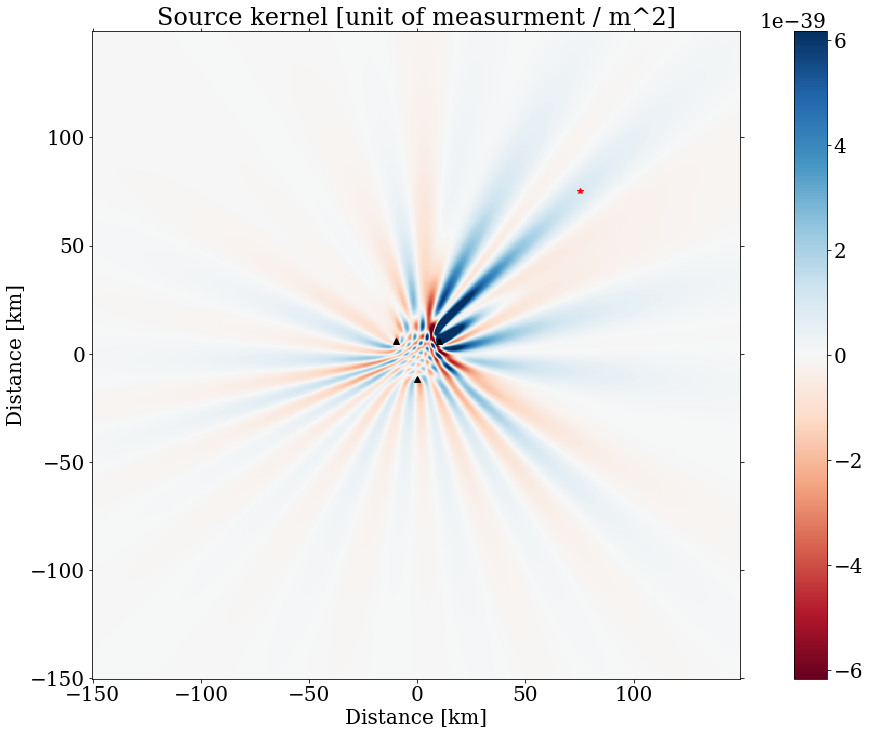

In [5]:
mpl.rc('font', **{'size':20})

def plot_K(K,title="MFP",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.6,0.6])
    cmap = plt.get_cmap('RdBu')
    i = plt.pcolor((x-p.dx/2)/1000,(y-p.dy/2)/1000,K,cmap='RdBu',rasterized=True)#,vmin=-4,vmax=4)
    if(cmax==0):
        cmax=np.max(np.abs(K))*0.15
    plt.clim(-cmax,cmax)
    plt.xlabel('Distance [km]')
    plt.ylabel('Distance [km]')
    plt.plot(x0/1000.0,y0/1000.0,'r*')
    plt.plot(xx,yy,'k^')
    plt.title(title)
    plt.axis('equal')
    ax.tick_params(top=True,right=True)
    colorbar_ax = fig.add_axes([0.75, 0.1, 0.03, 0.6])
    fig.colorbar(i, cax=colorbar_ax)
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()

plot_K(K_sum,title="Source kernel [unit of measurment / m^2]",save=1,savename="4_MFP_by_kernels.pdf")
